In [1]:
import numpy as np
import torch
import pyepo

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
num_node = 20 # node size
num_data = 100 # number of training data
num_feat = 10 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.tsp.genData(num_data+100+1000, num_feat, num_node, deg, e, seed=42)

In [3]:
from model import tspDFJModel
# set solver
optmodel = tspDFJModel(num_node)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
tour = optmodel.getTour(sol)
print(" -> ".join(map(str, tour)))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-22
Obj: 58.2849
0 -> 5 -> 3 -> 17 -> 1 -> 12 -> 4 -> 18 -> 9 -> 16 -> 7 -> 2 -> 14 -> 6 -> 13 -> 11 -> 19 -> 8 -> 15 -> 10 -> 0


In [4]:
# split data
from sklearn.model_selection import train_test_split
feats, x_test, costs, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
x_train, x_val, c_train, c_val = train_test_split(feats, costs, test_size=100, random_state=42)

In [5]:
# get training, validation and test dataset
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_val = pyepo.data.dataset.optDataset(optmodel, x_val, costs=c_val)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 121.50it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 122.03it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 132.86it/s]


In [6]:
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, x_train, costs=c_train)

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 57.53it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
from dataset import collate_fn
batch_size = 32
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_train = DataLoader(dataset_train, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, num_node*(num_node-1)//2)

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt

def plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw grad plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(grad_log, color="g", alpha=0.5, lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.gca().yaxis.get_offset_text().set_size(24)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Abs Grad", fontsize=36)
    plt.title("Absolute Gradient Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-10, num_epochs+10)
    plt.ylim(0, 0.8)
    plt.xticks(range(0, num_epochs+1, 50), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
lr = 5e-2
num_epochs = 400
log_step = 20

In [11]:
import time
from tqdm import tqdm
from earlystop import earlyStopper

def pipeline(reg, forward_func, loss_func, lr, num_epochs, log_step, loader_train, loader_val, loader_test, seed=42):
    # set random seed
    np.random.seed(42)
    torch.manual_seed(42)
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set stopper
    stopper = earlyStopper(patience=3)
    stop = False
    # init log
    loss_log = []
    grad_log = []
    regret_log_trn = []
    regret_log_val = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # eval & log
        if epoch % log_step == 0:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
            regret_log_val.append(regret_val)
            tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                       format(epoch, regret_trn*100, regret_val*100))
            # early stop
            if stopper.stop(regret_val):
                print()
                stop = True
                print("Early Stop!")
                break
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            # forward pass
            loss = forward_func(data, reg, loss_func, grad_log)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    # no early stop
    if not stop:
        regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
        regret_log_trn.append(regret_trn)
        regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
        regret_log_val.append(regret_val)
        tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                   format(epoch, regret_trn*100, regret_val*100))
    print()
    print("Evaluation:")
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, grad_log, regret_log_trn, regret_log_val

def forwardCAVE(data, reg, loss_func, grad_log):
    # unzip data
    x, _, _, t_ctr = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, t_ctr)
    return loss

### 2-Stage 

In [12]:
# init model
reg = LinearRegression()

In [13]:
from torch import nn
# init loss
mse = nn.MSELoss()

def forward2S(data, reg, loss_func, grad_log):
    # unzip data
    x, c, w, z = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, c)
    return loss

In [14]:
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forward2S, mse, lr, num_epochs, log_step,
                                                              loader_train_cost, loader_val, loader_test)

  0%|                                                                                          | 0/400 [00:01<?, ?it/s]

Epoch   0, Train Regret: 203.1834%, Val Regret: 196.1461%


Epoch   19, Loss:  16.7379:   5%|██▋                                                  | 20/400 [00:23<06:28,  1.02s/it]

Epoch  20, Train Regret:  22.0923%, Val Regret:  24.3278%


Epoch   39, Loss:  11.9884:  10%|█████▎                                               | 40/400 [00:45<06:06,  1.02s/it]

Epoch  40, Train Regret:  19.9259%, Val Regret:  21.4138%


Epoch   59, Loss:  17.5979:  15%|███████▉                                             | 60/400 [01:08<05:47,  1.02s/it]

Epoch  60, Train Regret:  17.2210%, Val Regret:  18.3424%


Epoch   79, Loss:  11.7784:  20%|██████████▌                                          | 80/400 [01:30<05:26,  1.02s/it]

Epoch  80, Train Regret:  16.2326%, Val Regret:  16.8206%


Epoch   99, Loss:   6.9238:  25%|█████████████                                       | 100/400 [01:52<05:06,  1.02s/it]

Epoch 100, Train Regret:  15.8126%, Val Regret:  17.3083%


Epoch  119, Loss:   6.7674:  30%|███████████████▌                                    | 120/400 [02:14<04:45,  1.02s/it]

Epoch 120, Train Regret:  16.3883%, Val Regret:  16.9691%


Epoch  139, Loss:   6.2347:  35%|██████████████████▏                                 | 140/400 [02:36<04:25,  1.02s/it]

Epoch 140, Train Regret:  15.4110%, Val Regret:  16.2912%


Epoch  159, Loss:  16.3207:  40%|████████████████████▊                               | 160/400 [02:58<04:04,  1.02s/it]

Epoch 160, Train Regret:  14.9757%, Val Regret:  16.5433%


Epoch  179, Loss:   6.1062:  45%|███████████████████████▍                            | 180/400 [03:20<03:44,  1.02s/it]

Epoch 180, Train Regret:  15.4578%, Val Regret:  16.9749%


Epoch  199, Loss:   4.2593:  50%|██████████████████████████                          | 200/400 [03:42<03:42,  1.11s/it]


Epoch 200, Train Regret:  15.1677%, Val Regret:  16.4125%

Early Stop!

Evaluation:
Test Regret: 16.4191%
Training Elapsed Time: 1.95 Sec


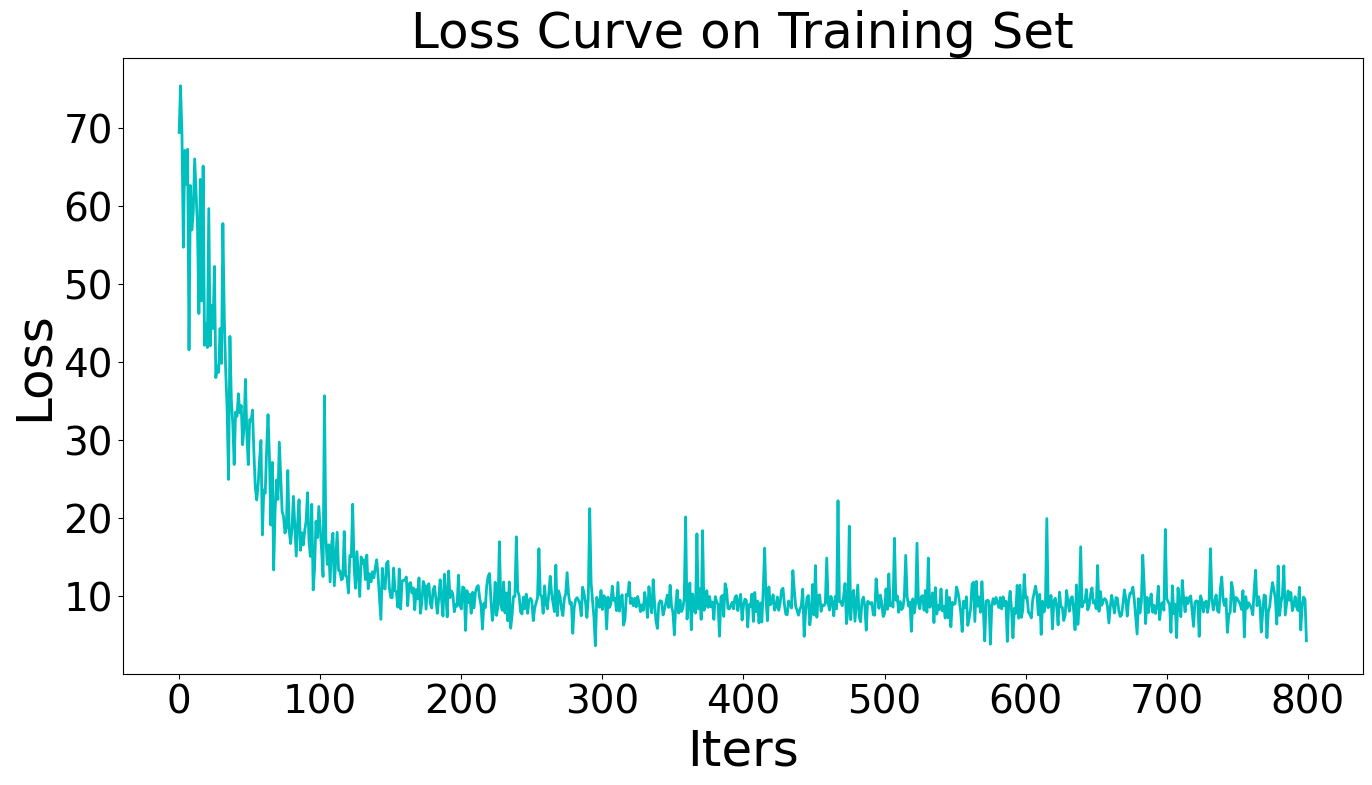

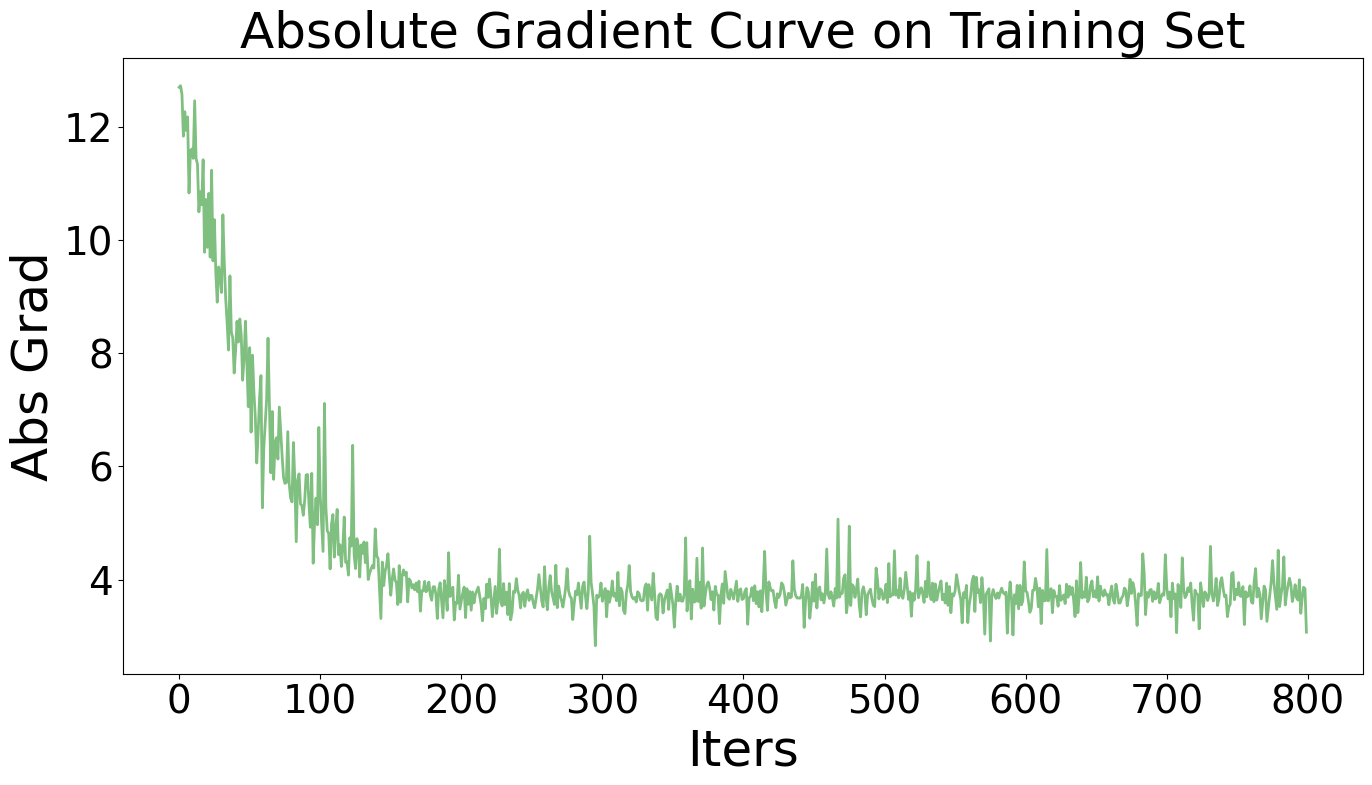

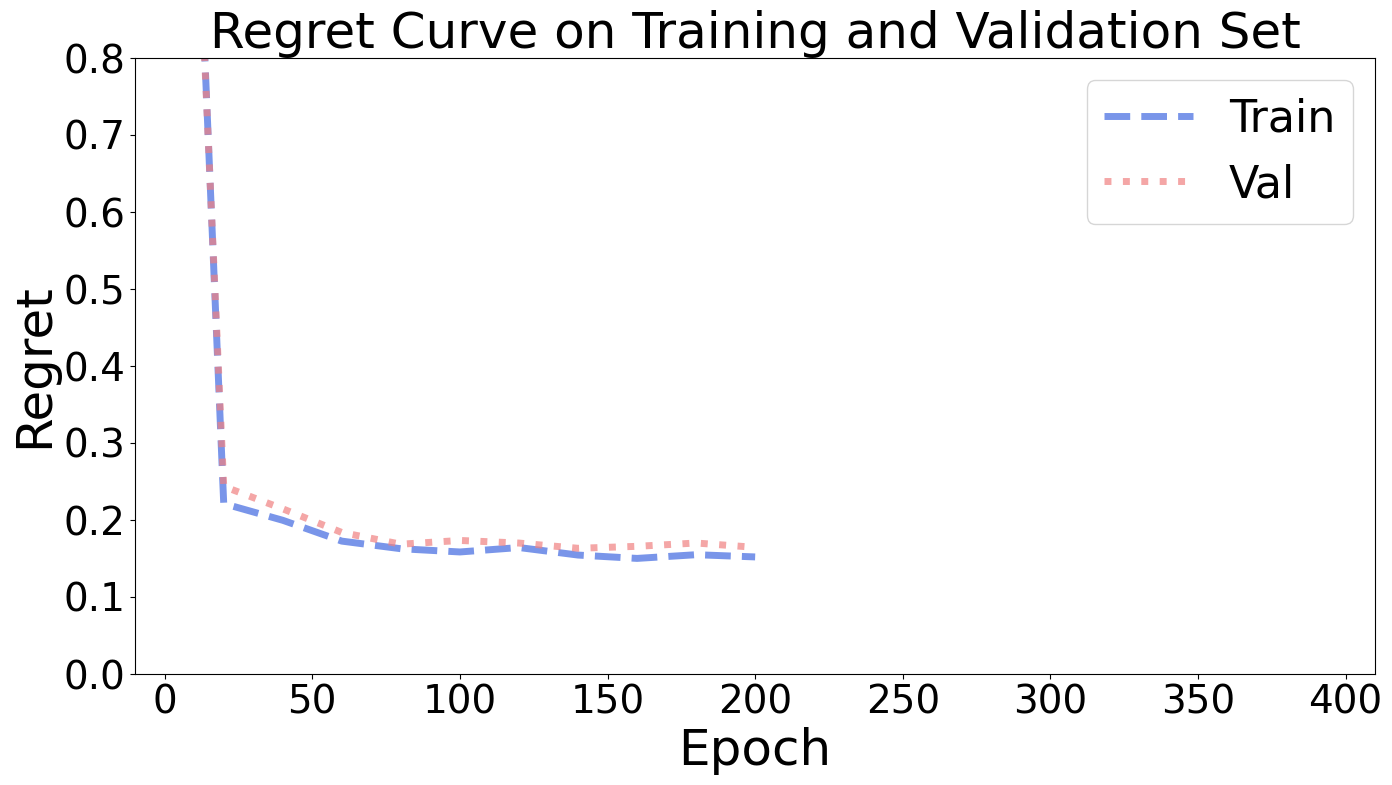

In [15]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Exact Method with Clarabel

In [16]:
# init model
reg = LinearRegression()

In [17]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="clarabel", processes=8)

Num of cores: 8


In [18]:
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/400 [00:01<?, ?it/s]

Epoch   0, Train Regret: 211.5036%, Val Regret: 210.5897%


Epoch   19, Loss:  -1.0000:   5%|██▋                                                  | 20/400 [00:32<07:54,  1.25s/it]

Epoch  20, Train Regret:  13.1887%, Val Regret:  31.7230%


Epoch   39, Loss:  -1.0000:  10%|█████▎                                               | 40/400 [00:59<07:32,  1.26s/it]

Epoch  40, Train Regret:   9.5011%, Val Regret:  29.2004%


Epoch   59, Loss:  -1.0000:  15%|███████▉                                             | 60/400 [01:25<07:04,  1.25s/it]

Epoch  60, Train Regret:   6.8973%, Val Regret:  28.7115%


Epoch   79, Loss:  -1.0000:  20%|██████████▌                                          | 80/400 [01:52<06:45,  1.27s/it]

Epoch  80, Train Regret:   5.2724%, Val Regret:  28.4267%


Epoch   99, Loss:  -1.0000:  25%|█████████████                                       | 100/400 [02:19<06:16,  1.25s/it]

Epoch 100, Train Regret:   3.3136%, Val Regret:  28.3098%


Epoch  119, Loss:  -1.0000:  30%|███████████████▌                                    | 120/400 [02:45<05:50,  1.25s/it]

Epoch 120, Train Regret:   0.2272%, Val Regret:  28.3098%


Epoch  139, Loss:  -1.0000:  35%|██████████████████▏                                 | 140/400 [03:12<05:28,  1.26s/it]

Epoch 140, Train Regret:   0.0000%, Val Regret:  28.3098%


Epoch  159, Loss:  -1.0000:  40%|████████████████████▊                               | 160/400 [03:38<05:28,  1.37s/it]


Epoch 160, Train Regret:   0.0000%, Val Regret:  28.3098%

Early Stop!

Evaluation:
Test Regret: 28.8442%
Training Elapsed Time: 44.16 Sec


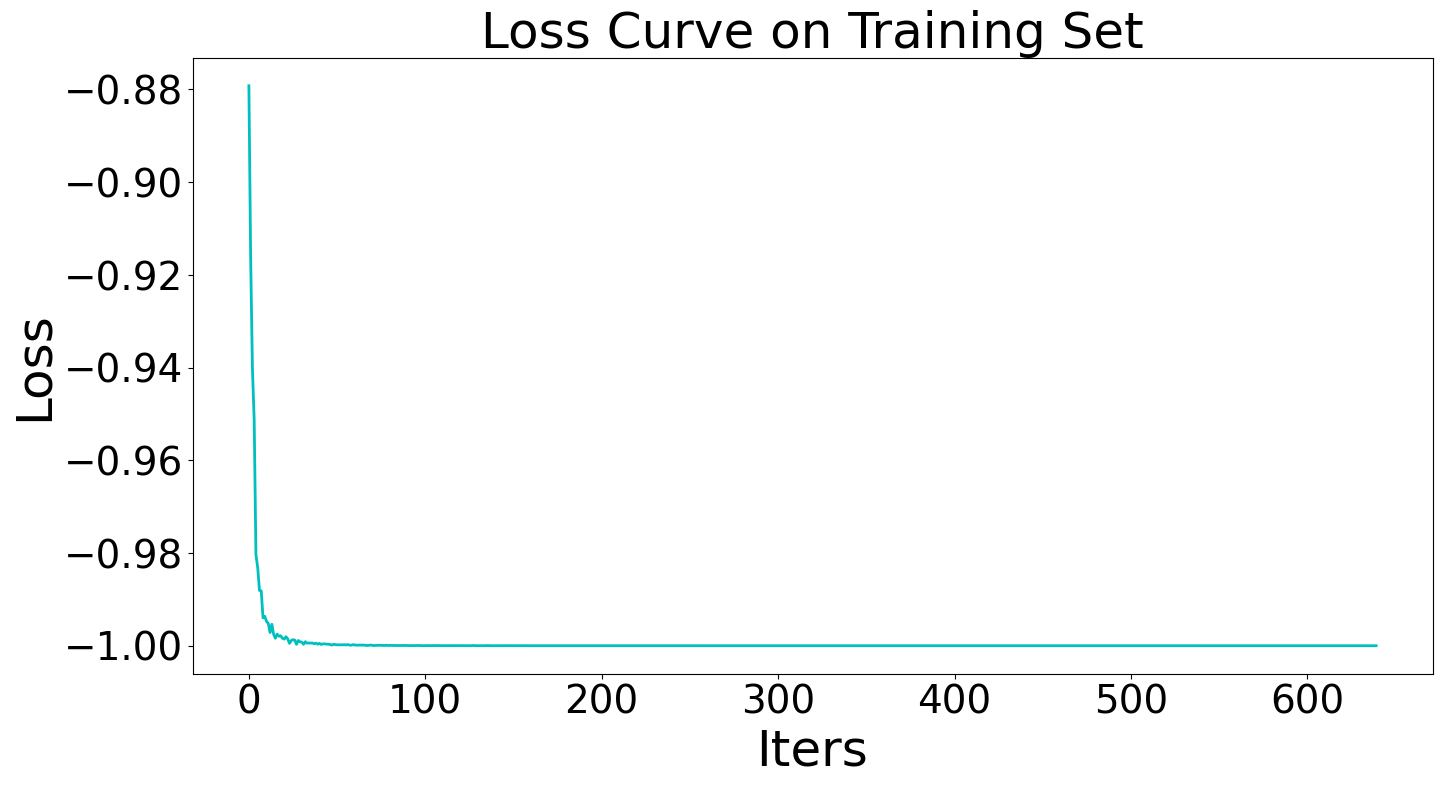

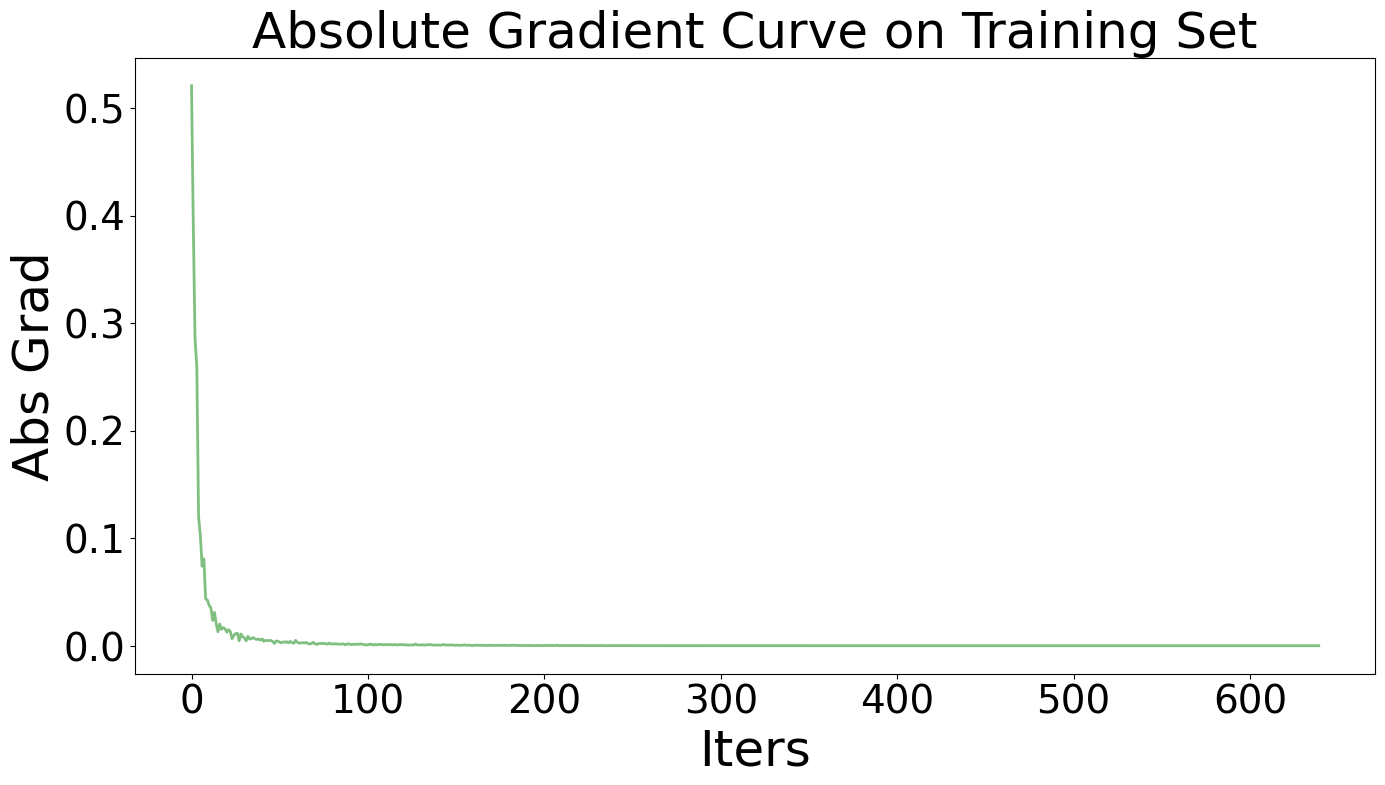

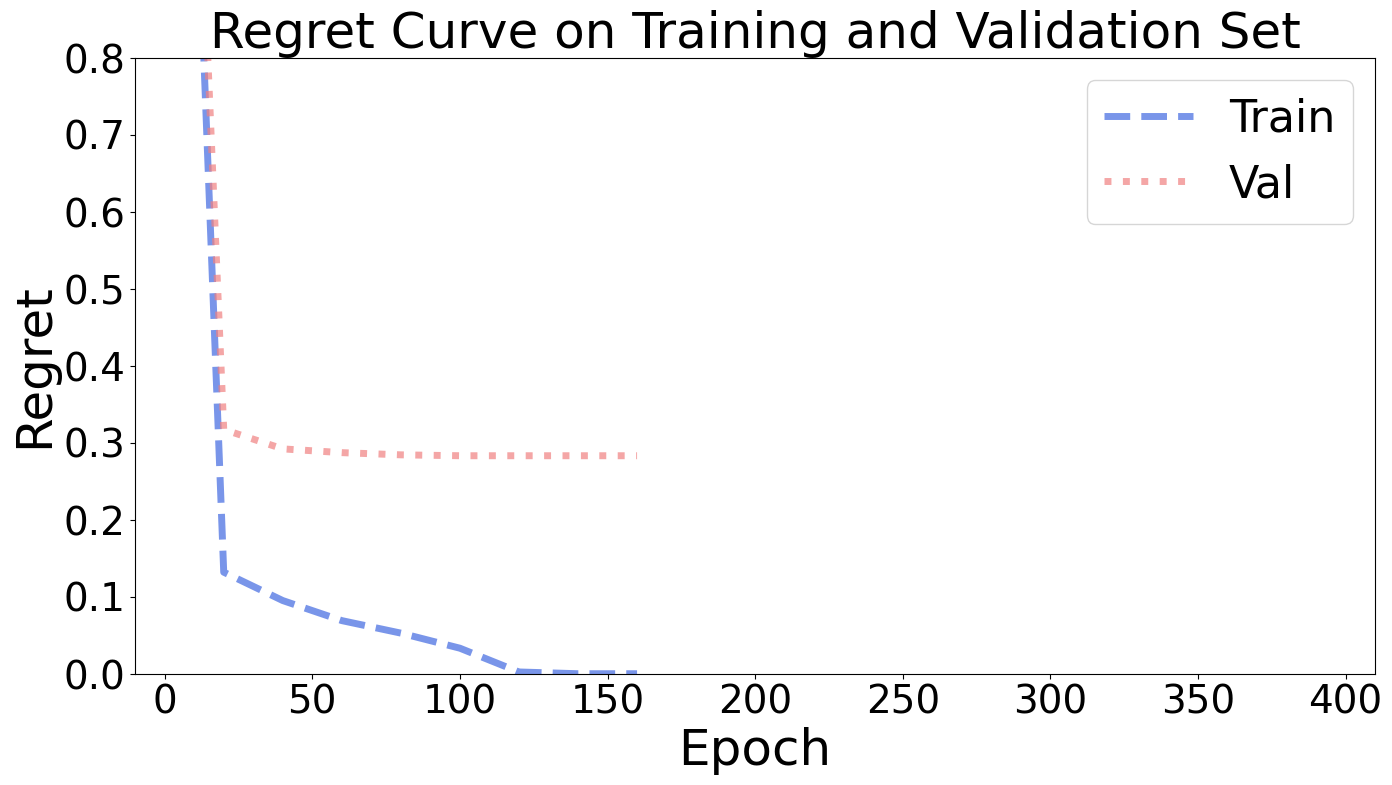

In [19]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Exact Method with NNLS

In [20]:
# init model
reg = LinearRegression()

In [21]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="nnls", processes=8)

Num of cores: 8


In [22]:
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/400 [00:01<?, ?it/s]

Epoch   0, Train Regret: 202.8670%, Val Regret: 206.7925%


Epoch   19, Loss:  -0.9999:   5%|██▋                                                  | 20/400 [00:28<07:53,  1.24s/it]

Epoch  20, Train Regret:  10.0083%, Val Regret:  32.8079%


Epoch   39, Loss:  -1.0000:  10%|█████▎                                               | 40/400 [00:54<07:37,  1.27s/it]

Epoch  40, Train Regret:   7.7138%, Val Regret:  31.2461%


Epoch   59, Loss:  -1.0000:  15%|███████▉                                             | 60/400 [01:21<07:03,  1.25s/it]

Epoch  60, Train Regret:   5.1815%, Val Regret:  31.2414%


Epoch   79, Loss:  -1.0000:  20%|██████████▌                                          | 80/400 [01:48<06:46,  1.27s/it]

Epoch  80, Train Regret:   3.1310%, Val Regret:  31.1726%


Epoch   99, Loss:  -1.0000:  25%|█████████████                                       | 100/400 [02:14<06:16,  1.25s/it]

Epoch 100, Train Regret:   1.1326%, Val Regret:  31.2509%


Epoch  119, Loss:  -1.0000:  30%|███████████████▌                                    | 120/400 [02:41<05:49,  1.25s/it]

Epoch 120, Train Regret:   0.0000%, Val Regret:  31.2509%


Epoch  139, Loss:  -1.0000:  35%|██████████████████▏                                 | 140/400 [03:07<05:48,  1.34s/it]


Epoch 140, Train Regret:   0.0000%, Val Regret:  31.2509%

Early Stop!

Evaluation:
Test Regret: 28.7322%
Training Elapsed Time: 34.29 Sec


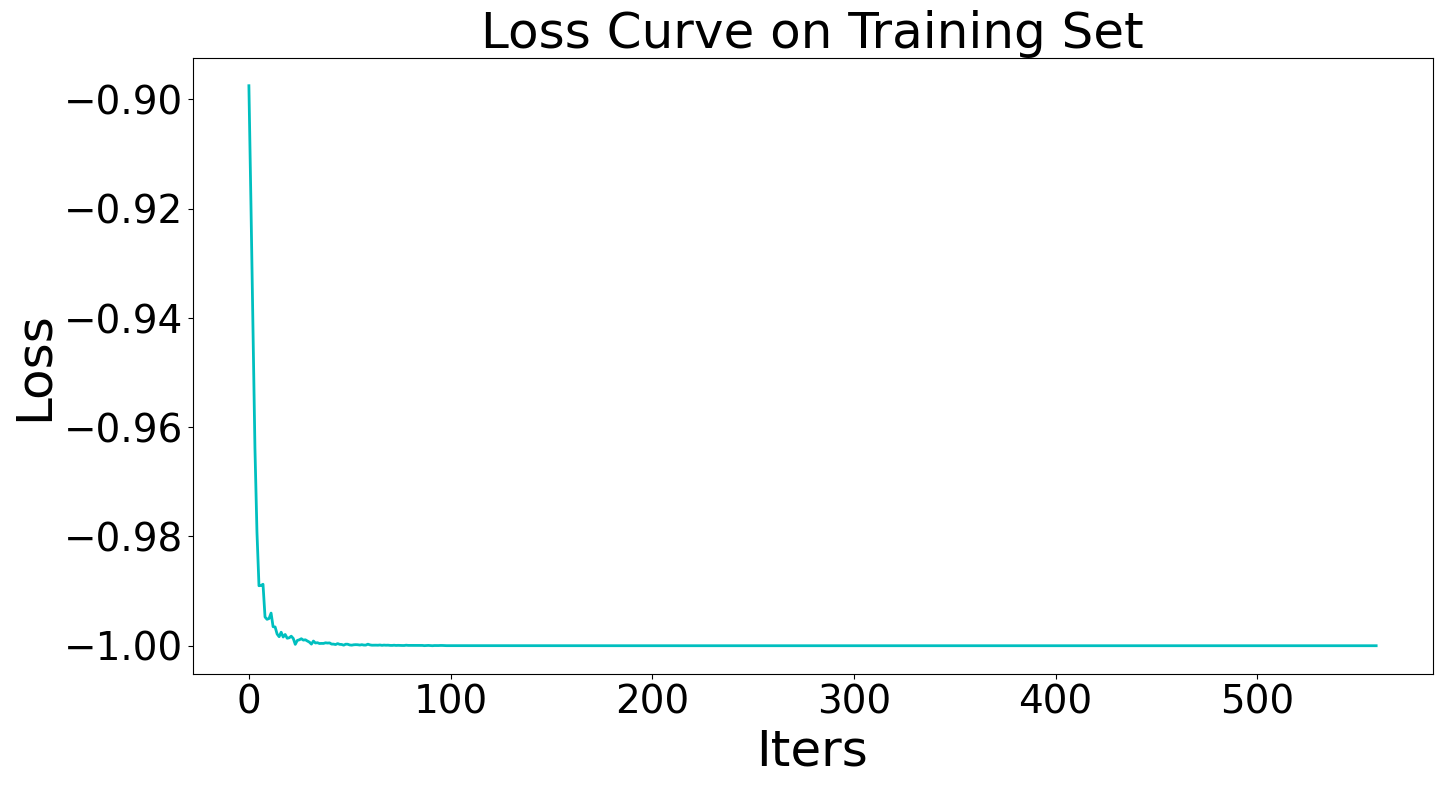

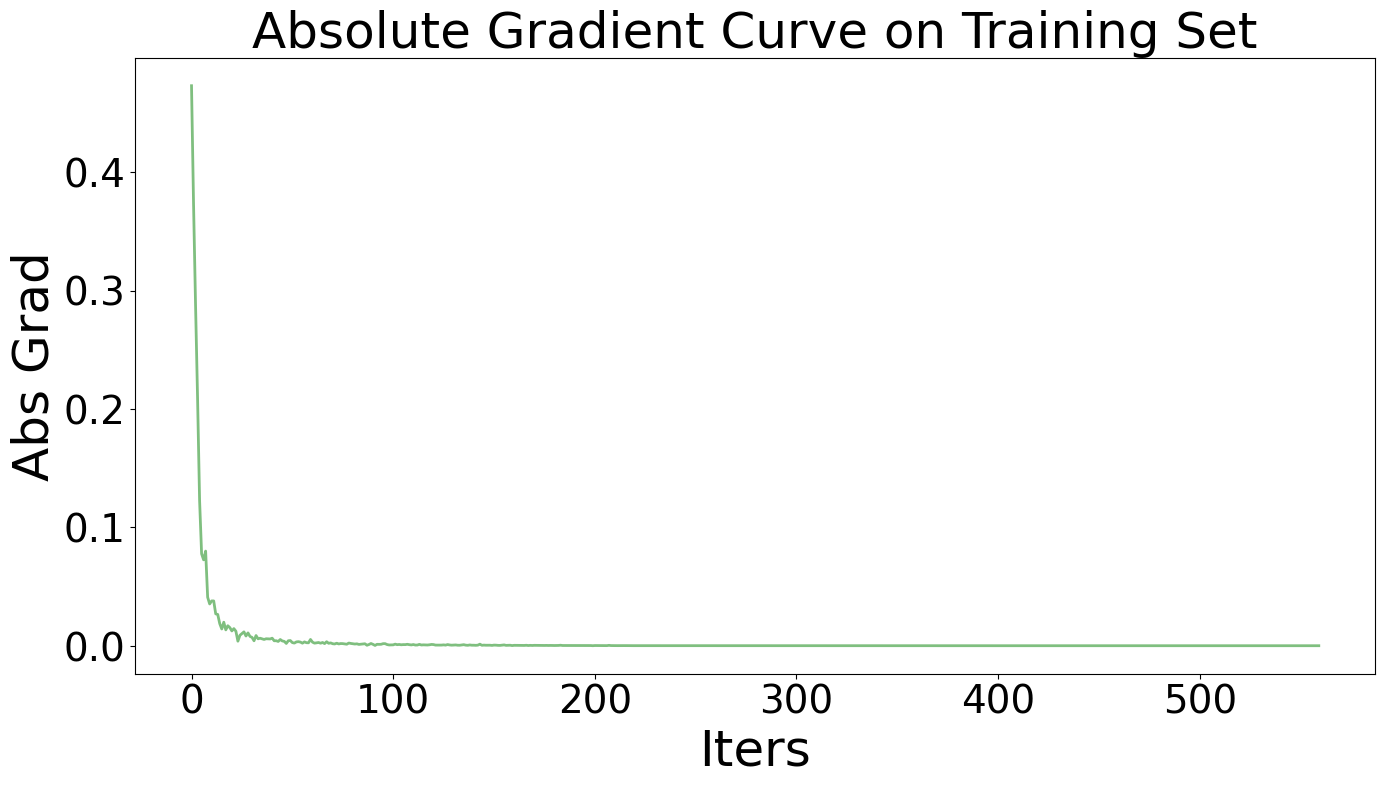

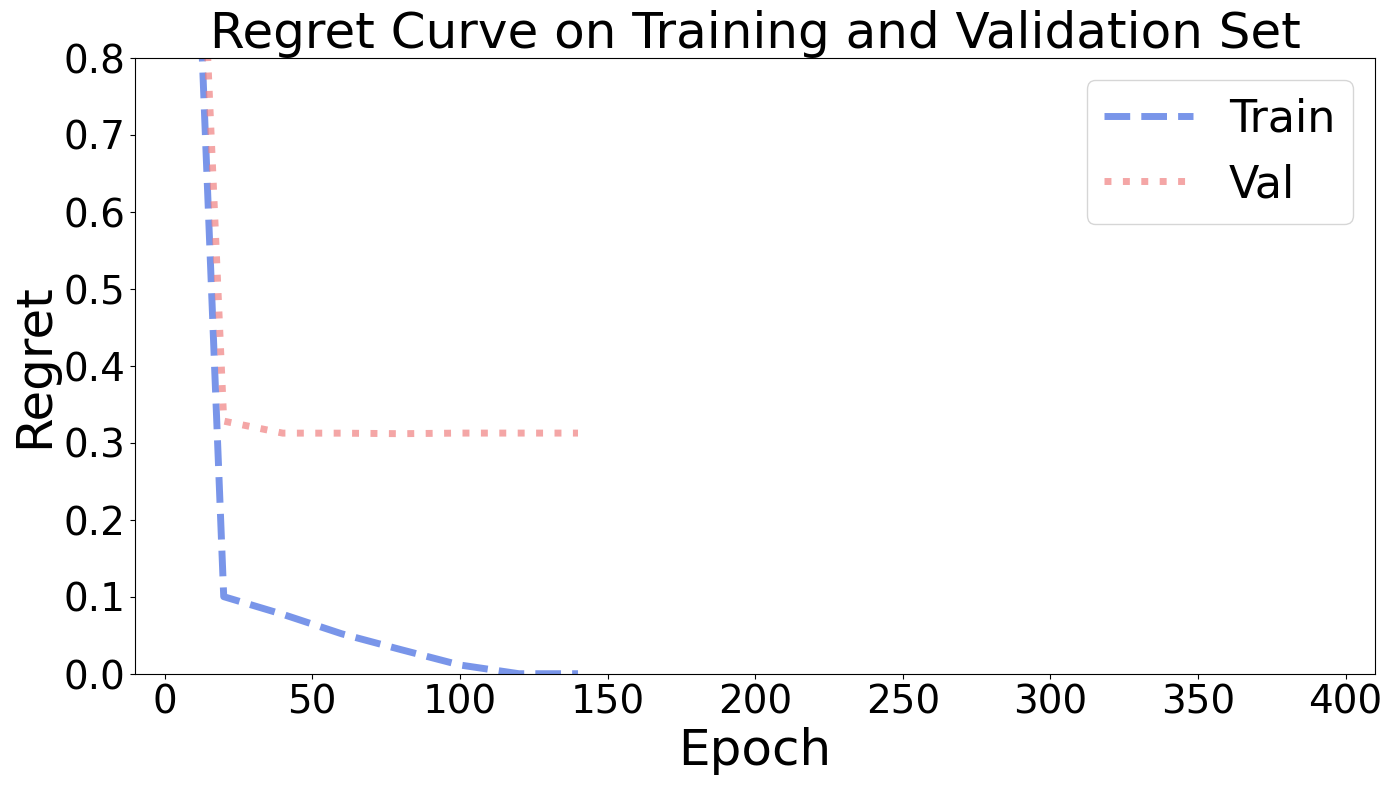

In [23]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method

In [24]:
# init model
reg = LinearRegression()

In [25]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100)

In [26]:
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/400 [00:01<?, ?it/s]

Epoch   0, Train Regret: 203.9112%, Val Regret: 188.5452%


Epoch   19, Loss:  -0.7642:   5%|██▋                                                  | 20/400 [00:25<07:05,  1.12s/it]

Epoch  20, Train Regret:  15.7857%, Val Regret:  25.1848%


Epoch   39, Loss:  -0.7835:  10%|█████▎                                               | 40/400 [00:49<06:44,  1.12s/it]

Epoch  40, Train Regret:  15.8038%, Val Regret:  24.3563%


Epoch   59, Loss:  -0.7677:  15%|███████▉                                             | 60/400 [01:13<06:21,  1.12s/it]

Epoch  60, Train Regret:  15.5358%, Val Regret:  23.6214%


Epoch   79, Loss:  -0.7579:  20%|██████████▌                                          | 80/400 [01:37<05:56,  1.11s/it]

Epoch  80, Train Regret:  16.1459%, Val Regret:  22.6257%


Epoch   99, Loss:  -0.7933:  25%|█████████████                                       | 100/400 [02:01<05:35,  1.12s/it]

Epoch 100, Train Regret:  14.9742%, Val Regret:  22.4912%


Epoch  119, Loss:  -0.7548:  30%|███████████████▌                                    | 120/400 [02:26<05:11,  1.11s/it]

Epoch 120, Train Regret:  14.3500%, Val Regret:  24.5986%


Epoch  139, Loss:  -0.8058:  35%|██████████████████▏                                 | 140/400 [02:50<04:51,  1.12s/it]

Epoch 140, Train Regret:  14.7966%, Val Regret:  24.3475%


Epoch  159, Loss:  -0.7798:  40%|████████████████████▊                               | 160/400 [03:14<04:51,  1.21s/it]


Epoch 160, Train Regret:  13.5718%, Val Regret:  25.0247%

Early Stop!

Evaluation:
Test Regret: 24.1075%
Training Elapsed Time: 17.11 Sec


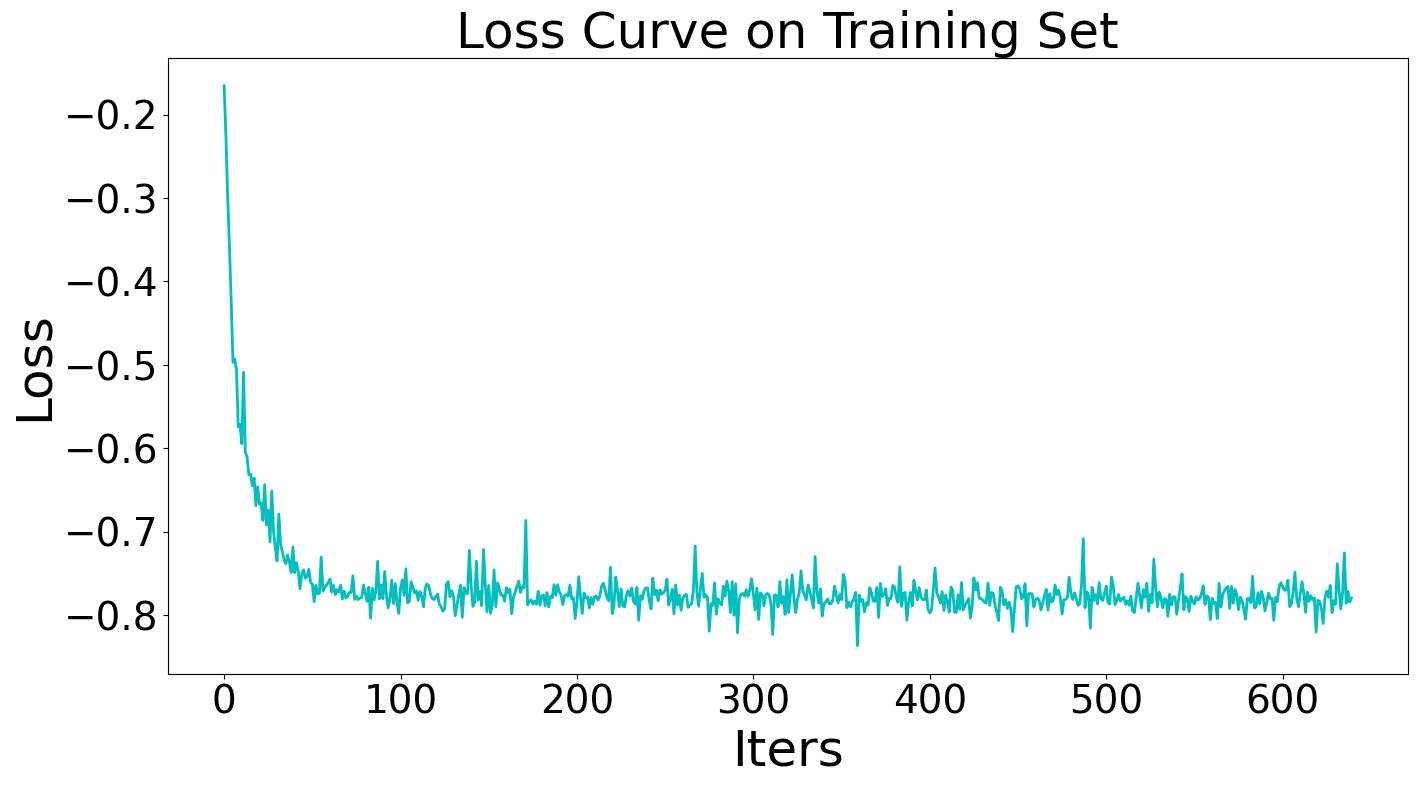

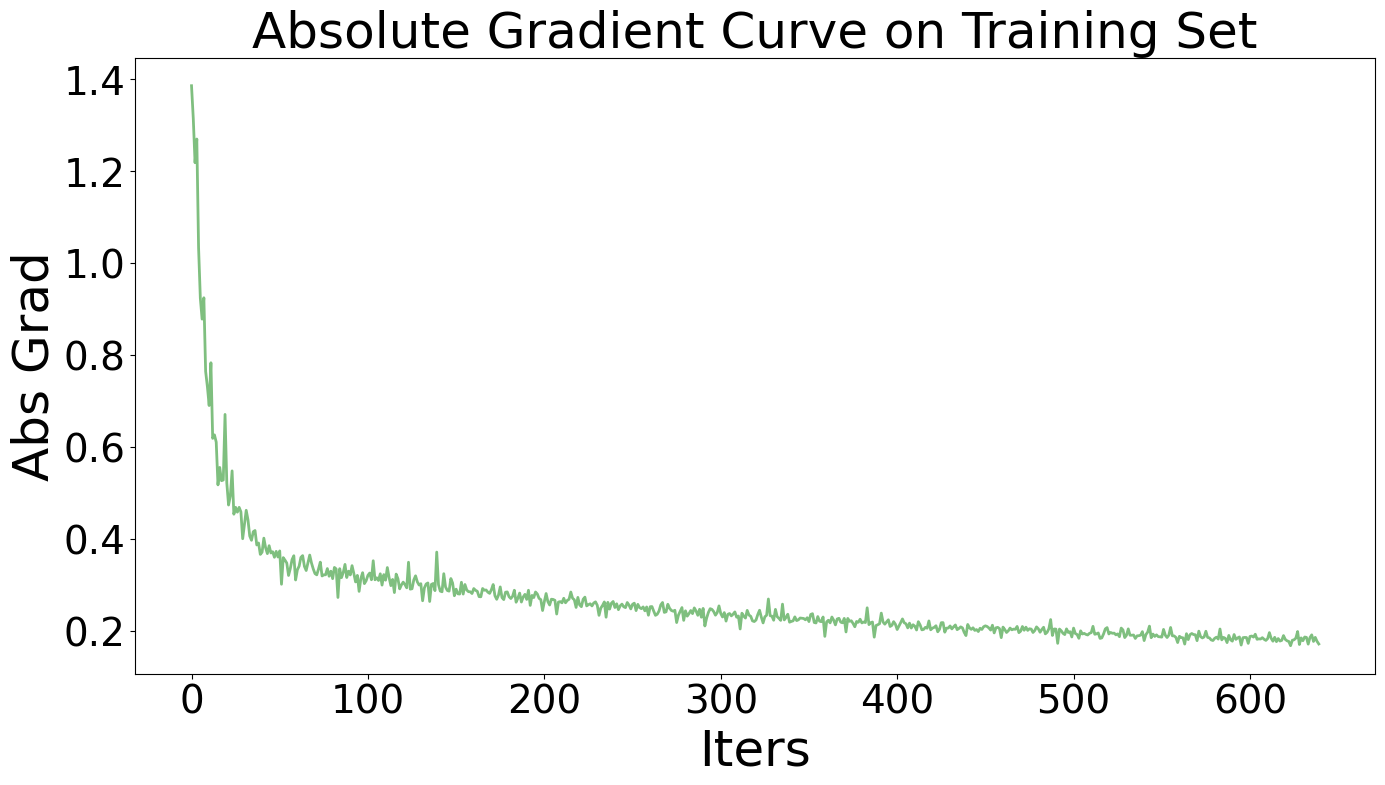

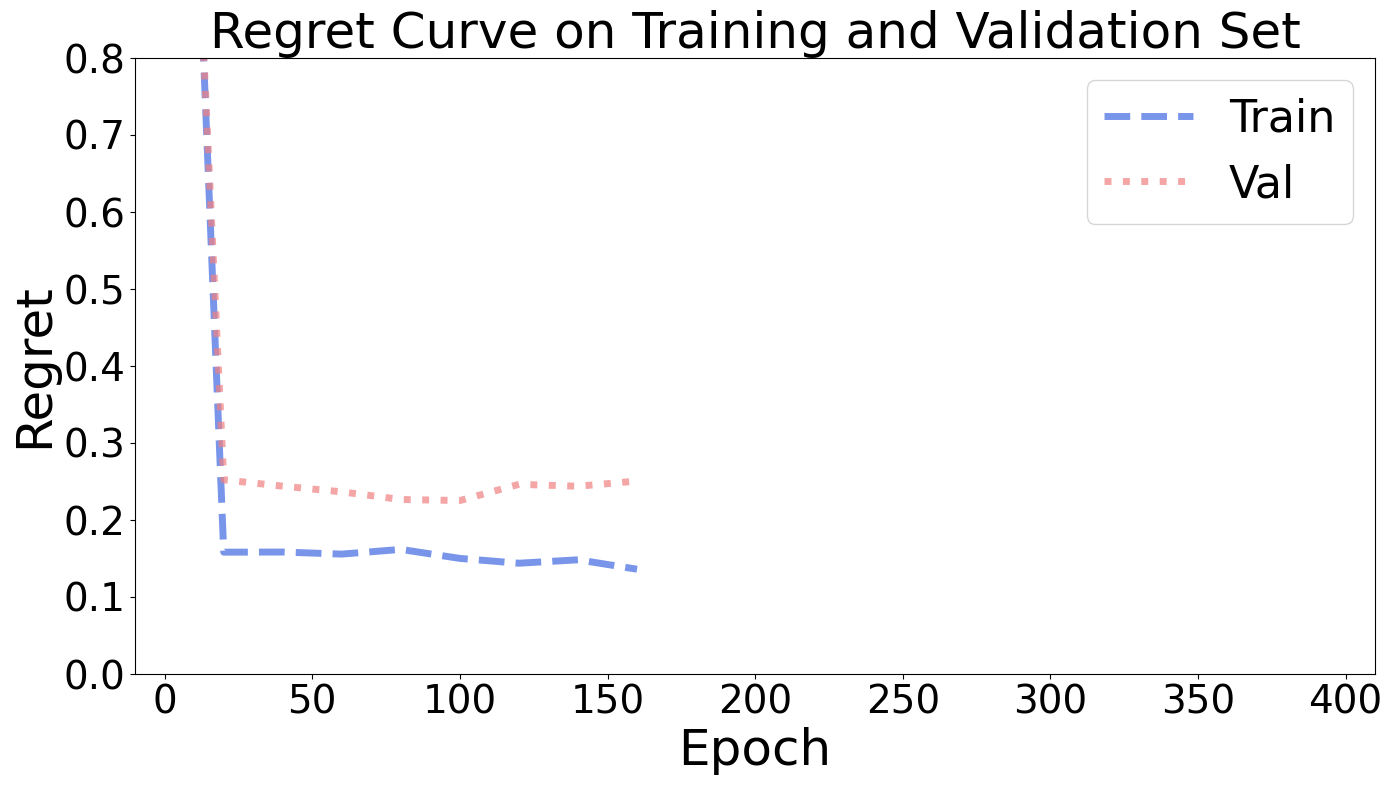

In [27]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Average Method 

In [28]:
# init model
reg = LinearRegression()

In [29]:
from func import avgConeAlignedCosine
# init loss
ca_cos = avgConeAlignedCosine(optmodel)

In [30]:
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/400 [00:01<?, ?it/s]

Epoch   0, Train Regret: 202.8670%, Val Regret: 206.7925%


Epoch   19, Loss:  -0.7106:   5%|██▋                                                  | 20/400 [00:24<06:30,  1.03s/it]

Epoch  20, Train Regret:  13.4217%, Val Regret:  22.1530%


Epoch   39, Loss:  -0.8004:  10%|█████▎                                               | 40/400 [00:46<06:11,  1.03s/it]

Epoch  40, Train Regret:  15.8327%, Val Regret:  22.7186%


Epoch   59, Loss:  -0.7822:  15%|███████▉                                             | 60/400 [01:09<05:51,  1.04s/it]

Epoch  60, Train Regret:  14.0303%, Val Regret:  24.7127%


Epoch   79, Loss:  -0.6919:  20%|██████████▌                                          | 80/400 [01:31<06:05,  1.14s/it]


Epoch  80, Train Regret:  13.6311%, Val Regret:  24.0800%

Early Stop!

Evaluation:
Test Regret: 22.9252%
Training Elapsed Time: 1.72 Sec


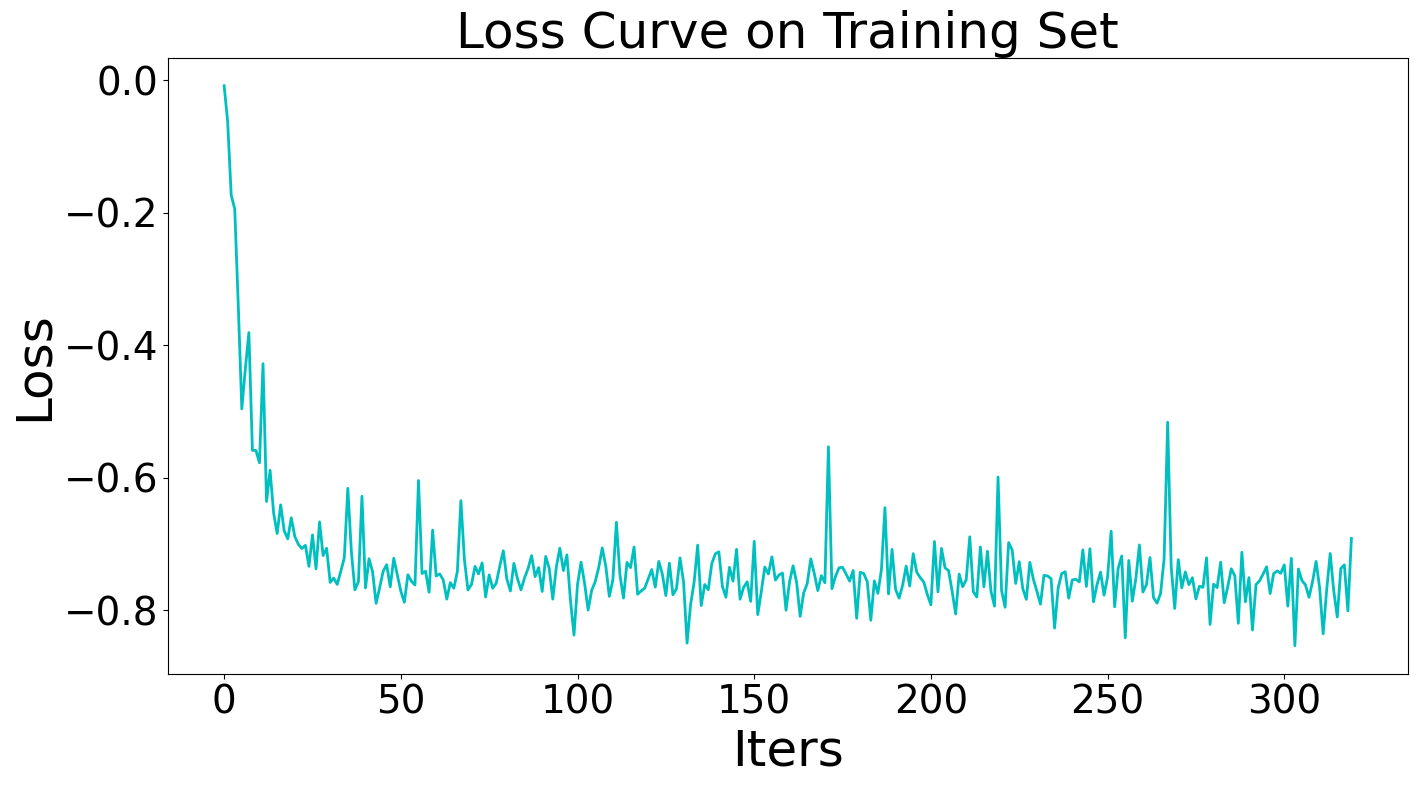

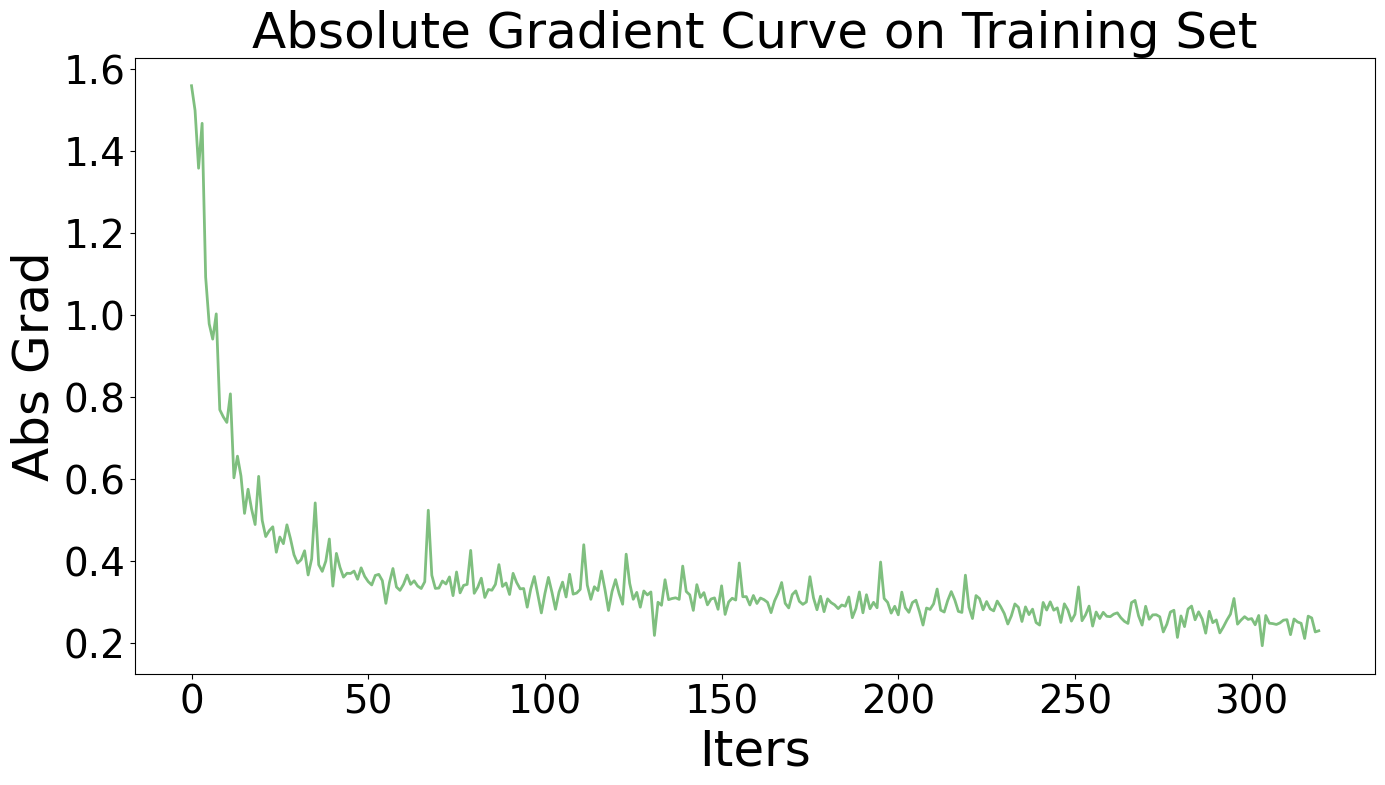

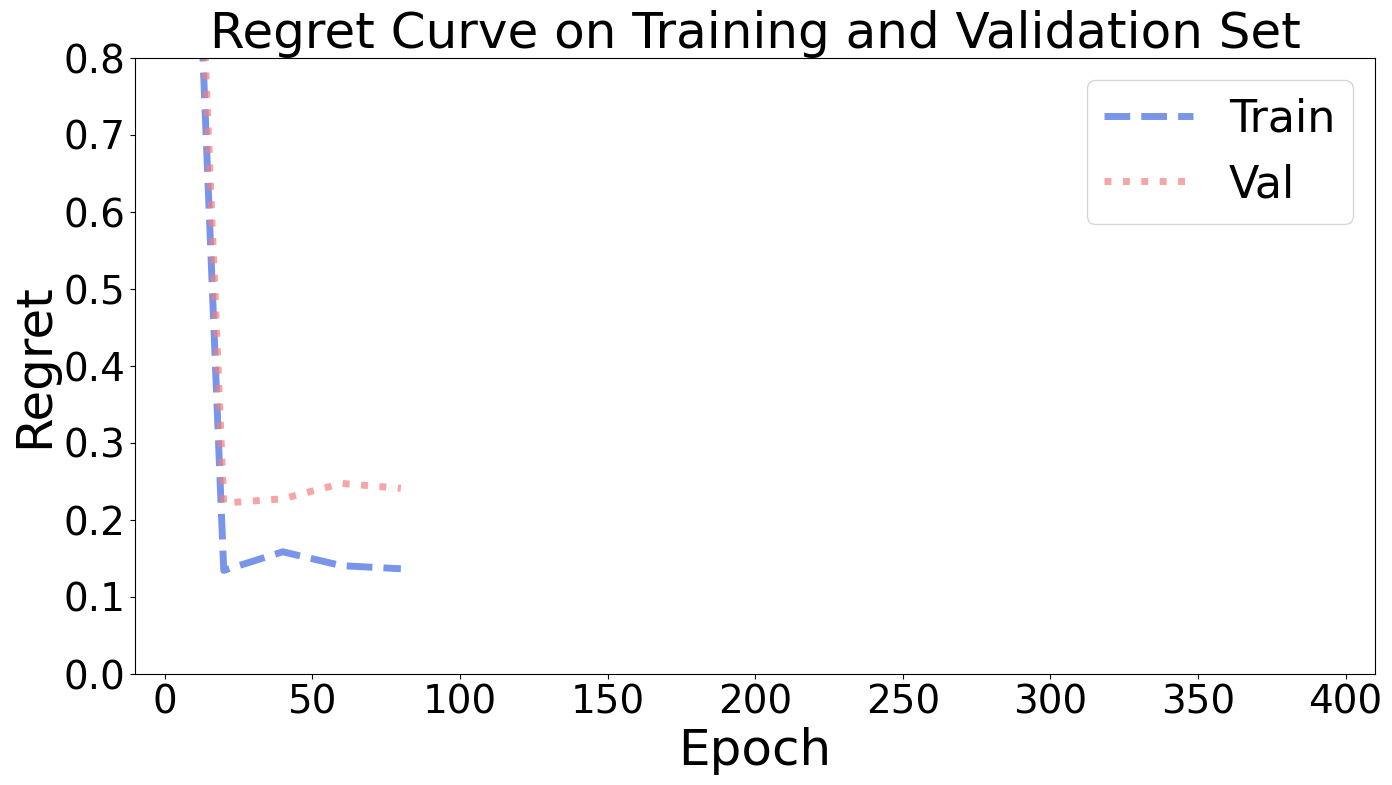

In [31]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sign Method 

In [32]:
# init model
reg = LinearRegression()

In [33]:
from func import signConeAlignedCosine
# init loss
ca_cos = signConeAlignedCosine(optmodel)

In [34]:
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/400 [00:01<?, ?it/s]

Epoch   0, Train Regret: 205.8668%, Val Regret: 200.9942%


Epoch   19, Loss:  -0.9984:   5%|██▋                                                  | 20/400 [00:23<06:31,  1.03s/it]

Epoch  20, Train Regret:  16.9708%, Val Regret:  32.3707%


Epoch   39, Loss:  -0.9993:  10%|█████▎                                               | 40/400 [00:46<06:11,  1.03s/it]

Epoch  40, Train Regret:  16.2676%, Val Regret:  31.2639%


Epoch   59, Loss:  -0.9991:  15%|███████▉                                             | 60/400 [01:08<05:50,  1.03s/it]

Epoch  60, Train Regret:  14.0815%, Val Regret:  34.3459%


Epoch   79, Loss:  -0.9995:  20%|██████████▌                                          | 80/400 [01:30<05:28,  1.03s/it]

Epoch  80, Train Regret:  15.6692%, Val Regret:  34.8256%


Epoch   99, Loss:  -0.9994:  25%|█████████████                                       | 100/400 [01:53<05:39,  1.13s/it]


Epoch 100, Train Regret:  15.4287%, Val Regret:  37.6816%

Early Stop!

Evaluation:
Test Regret: 34.9442%
Training Elapsed Time: 2.24 Sec


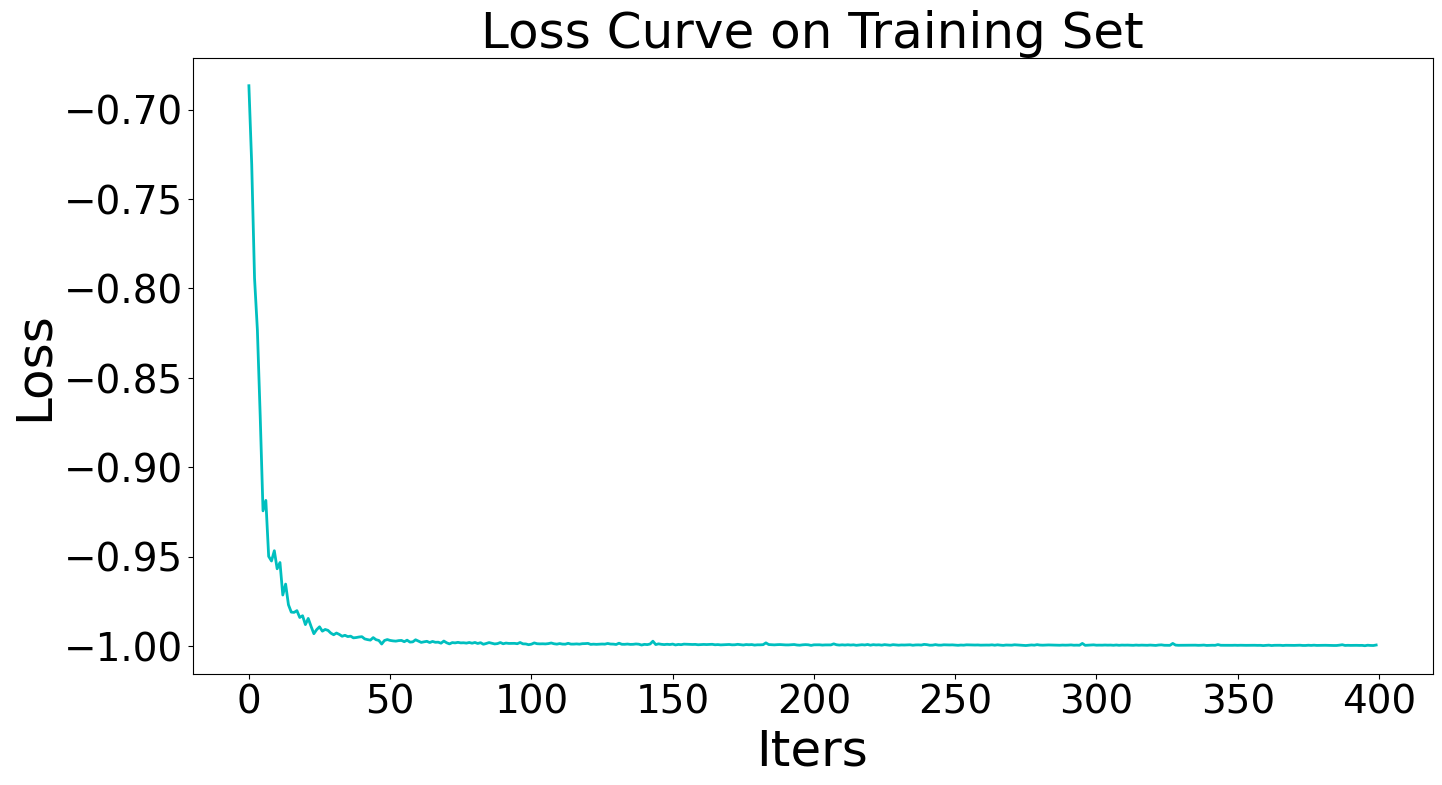

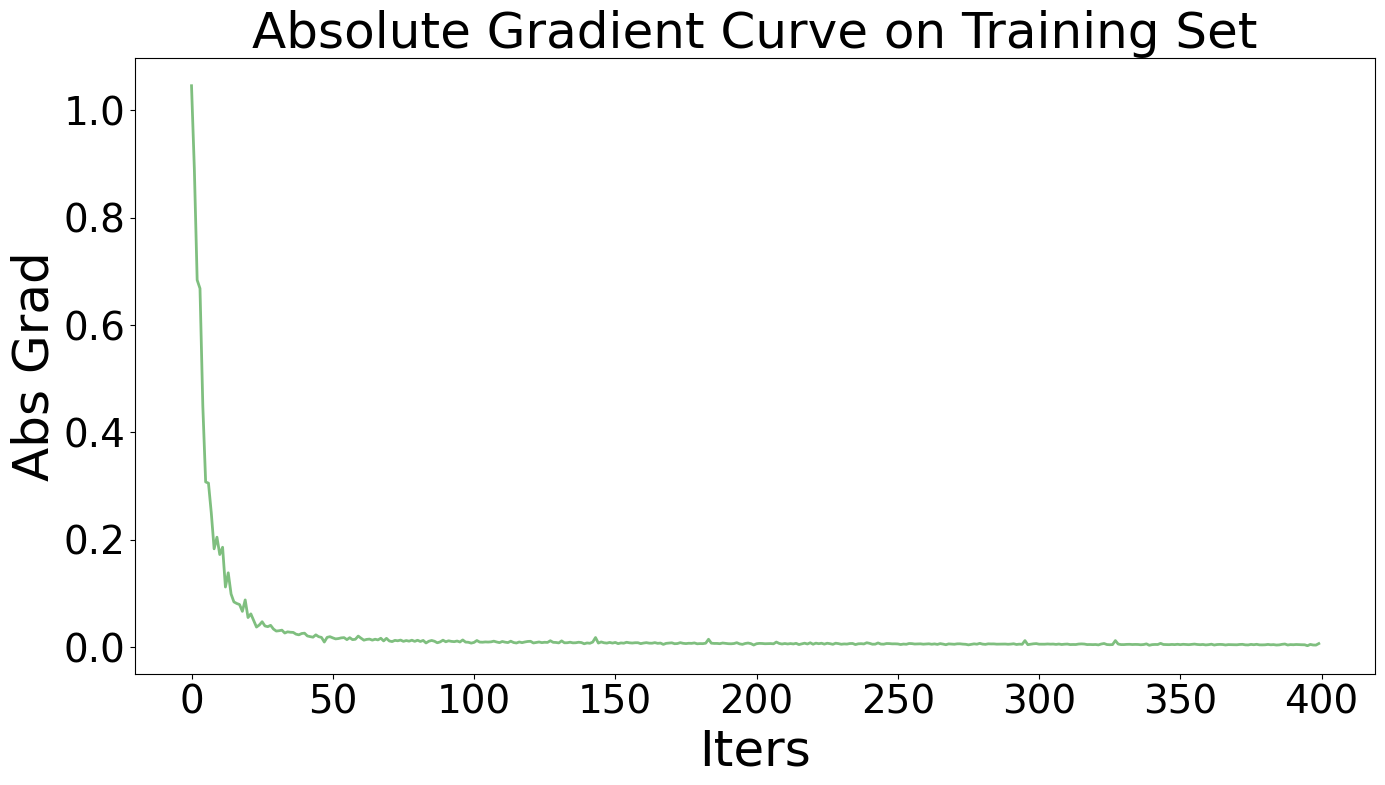

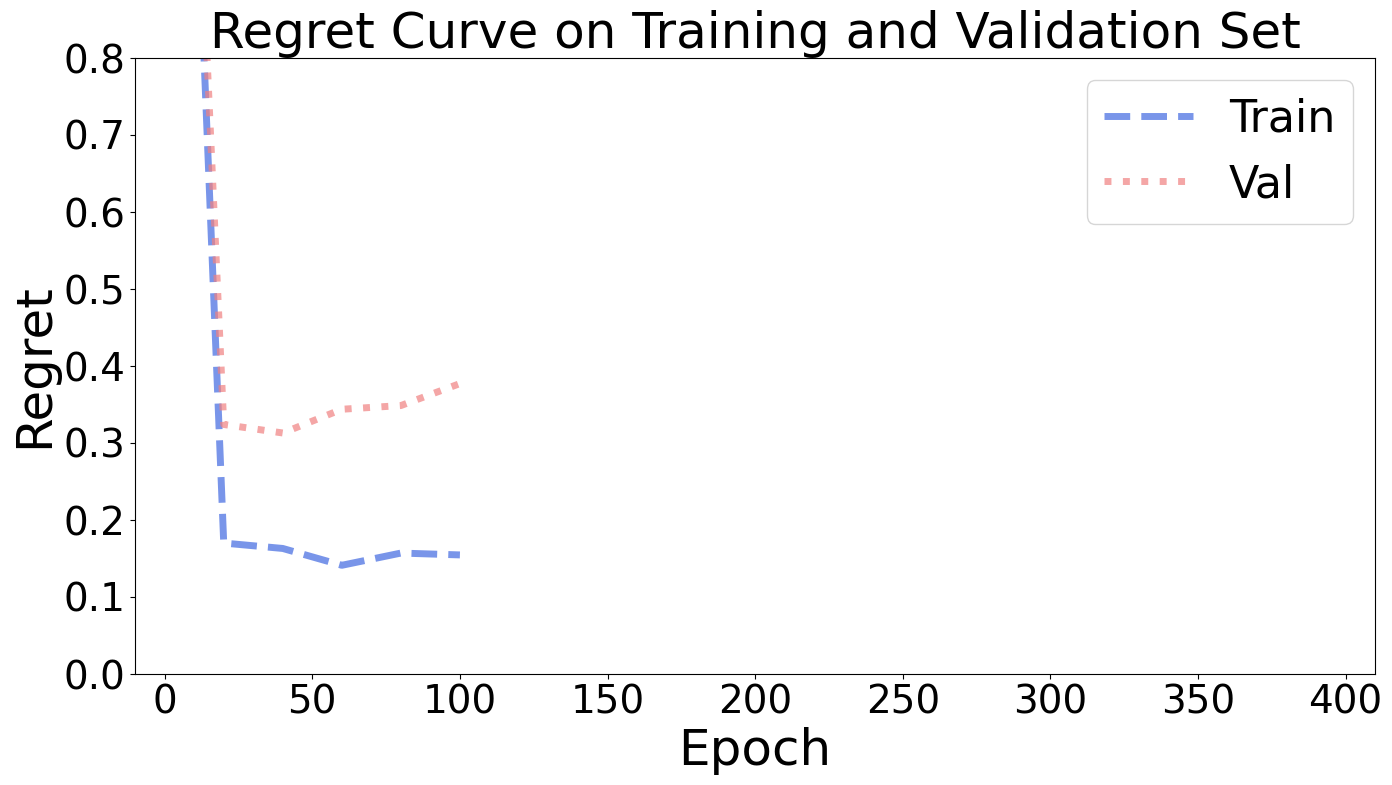

In [35]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### PFYL 

In [36]:
# init model
reg = LinearRegression()

In [37]:
from pyepo.func import perturbedFenchelYoung
# init pfyl loss
pfy = perturbedFenchelYoung(optmodel, n_samples=1, sigma=1.0, processes=8)

def forwardPFY(data, reg, loss_func, grad_log):
    # unzip data
    x, _, w, _ = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, w)
    return loss

Num of cores: 8


In [38]:
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardPFY, pfy, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/400 [00:01<?, ?it/s]

Epoch   0, Train Regret: 215.5825%, Val Regret: 195.3064%


Epoch   19, Loss:  12.5000:   5%|██▋                                                  | 20/400 [00:28<08:10,  1.29s/it]

Epoch  20, Train Regret:   5.5946%, Val Regret:  16.9158%


Epoch   39, Loss:   6.5000:  10%|█████▎                                               | 40/400 [00:56<07:39,  1.28s/it]

Epoch  40, Train Regret:   4.4537%, Val Regret:  18.0363%


Epoch   59, Loss:  14.0000:  15%|███████▉                                             | 60/400 [01:23<07:20,  1.30s/it]

Epoch  60, Train Regret:   3.9342%, Val Regret:  17.0229%


Epoch   79, Loss:   8.5000:  20%|██████████▌                                          | 80/400 [01:51<07:24,  1.39s/it]


Epoch  80, Train Regret:   2.1329%, Val Regret:  18.6683%

Early Stop!

Evaluation:
Test Regret: 16.2645%
Training Elapsed Time: 22.54 Sec


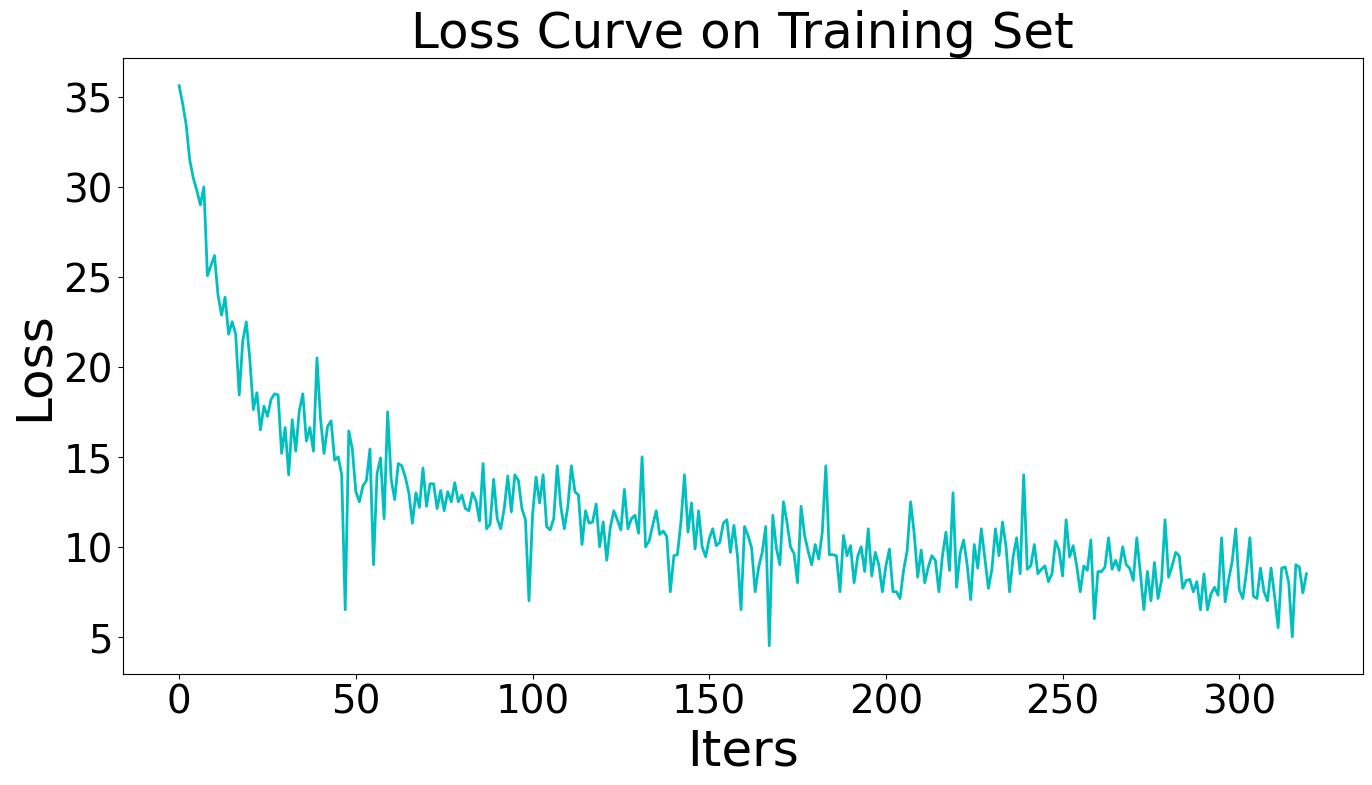

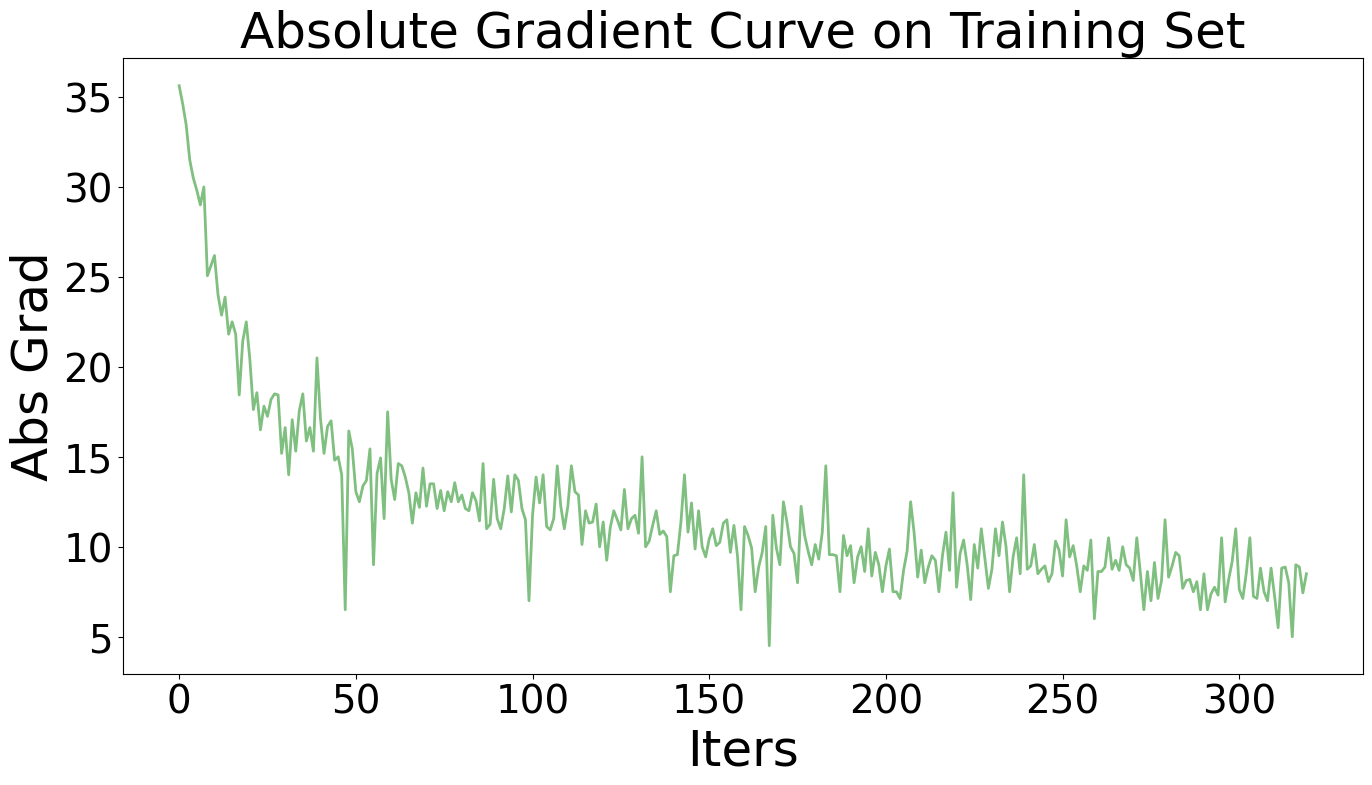

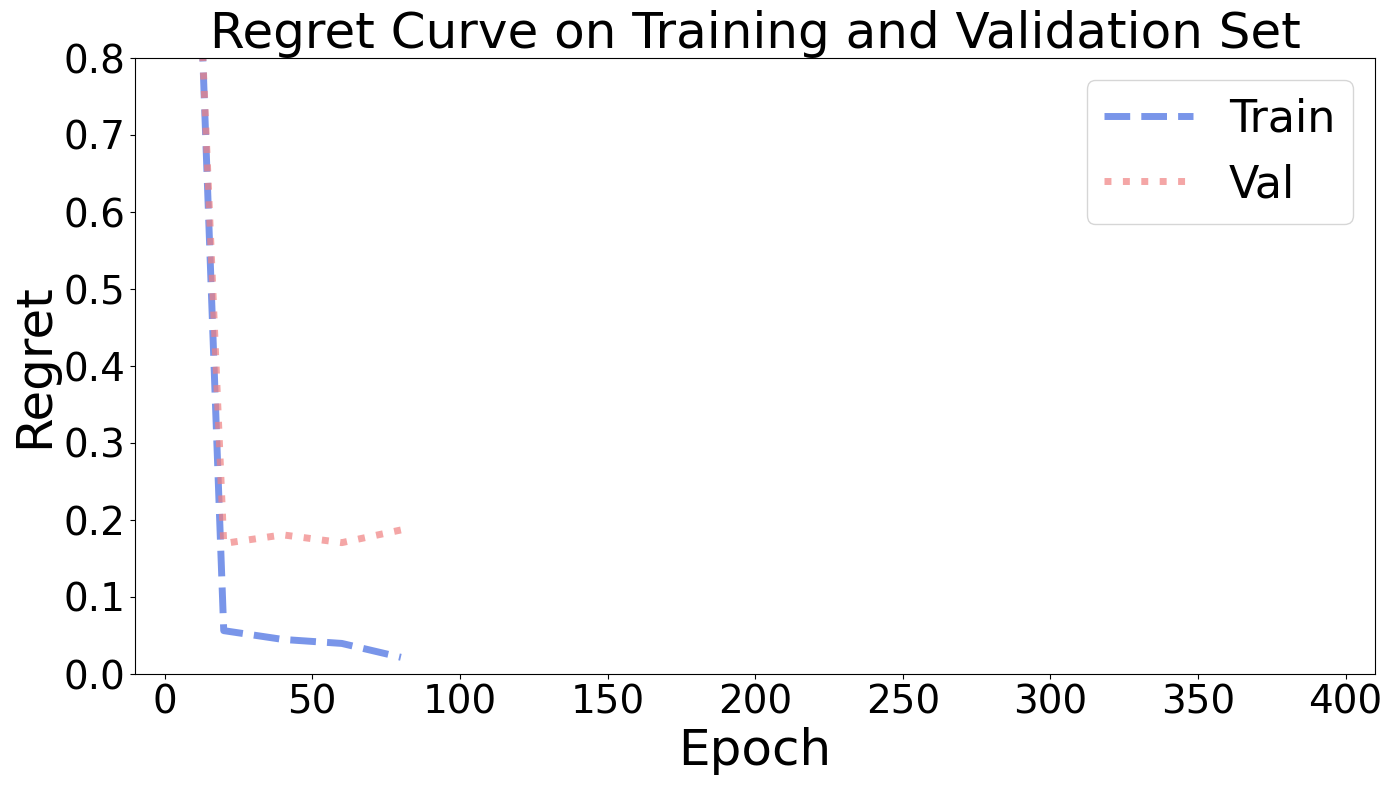

In [39]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### NCE 

In [40]:
# init model
reg = LinearRegression()

In [41]:
from pyepo.func import NCE
# init nce loss
nce = NCE(optmodel, processes=8, solve_ratio=0.05, dataset=dataset_train_cost)

def forwardNCE(data, reg, loss_func, grad_log):
    # unzip data
    x, _, w, _ = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, w)
    return loss

Num of cores: 8


In [42]:
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardNCE, nce, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/400 [00:01<?, ?it/s]

Epoch   0, Train Regret: 205.8668%, Val Regret: 200.9942%


Epoch   19, Loss: -208.9249:   5%|██▌                                                 | 20/400 [00:24<06:40,  1.05s/it]

Epoch  20, Train Regret:  18.3910%, Val Regret:  32.0015%


Epoch   39, Loss: -350.9855:  10%|█████▏                                              | 40/400 [00:46<06:14,  1.04s/it]

Epoch  40, Train Regret:  16.5795%, Val Regret:  30.1579%


Epoch   59, Loss: -510.2840:  15%|███████▊                                            | 60/400 [01:09<06:02,  1.06s/it]

Epoch  60, Train Regret:  15.5486%, Val Regret:  30.1512%


Epoch   79, Loss: -857.6702:  20%|██████████▍                                         | 80/400 [01:32<05:35,  1.05s/it]

Epoch  80, Train Regret:  15.9373%, Val Regret:  28.9544%


Epoch   99, Loss: -747.2281:  25%|████████████▊                                      | 100/400 [01:55<05:11,  1.04s/it]

Epoch 100, Train Regret:  15.0362%, Val Regret:  28.2611%


Epoch  119, Loss: -970.6949:  30%|███████████████▎                                   | 120/400 [02:18<05:00,  1.07s/it]

Epoch 120, Train Regret:  14.7650%, Val Regret:  27.0055%


Epoch  139, Loss: -932.3107:  35%|█████████████████▊                                 | 140/400 [02:40<04:35,  1.06s/it]

Epoch 140, Train Regret:  15.4089%, Val Regret:  26.8684%


Epoch  159, Loss: -1750.4730:  40%|████████████████████                              | 160/400 [03:03<04:11,  1.05s/it]

Epoch 160, Train Regret:  14.4262%, Val Regret:  27.0667%


Epoch  179, Loss: -1439.0283:  45%|██████████████████████▌                           | 180/400 [03:25<03:47,  1.03s/it]

Epoch 180, Train Regret:  15.1162%, Val Regret:  27.0620%


Epoch  199, Loss: -1413.6560:  50%|█████████████████████████                         | 200/400 [03:48<03:30,  1.05s/it]

Epoch 200, Train Regret:  14.4467%, Val Regret:  26.7249%


Epoch  219, Loss: -1882.2539:  55%|███████████████████████████▌                      | 220/400 [04:11<03:15,  1.08s/it]

Epoch 220, Train Regret:  14.0770%, Val Regret:  26.4391%


Epoch  239, Loss: -1745.5015:  60%|██████████████████████████████                    | 240/400 [04:34<02:51,  1.07s/it]

Epoch 240, Train Regret:  14.1440%, Val Regret:  25.9664%


Epoch  259, Loss: -2919.8726:  65%|████████████████████████████████▌                 | 260/400 [04:57<02:26,  1.05s/it]

Epoch 260, Train Regret:  13.6826%, Val Regret:  26.7108%


Epoch  279, Loss: -2335.2375:  70%|███████████████████████████████████               | 280/400 [05:19<02:03,  1.03s/it]

Epoch 280, Train Regret:  13.5124%, Val Regret:  26.2654%


Epoch  299, Loss: -2979.9121:  75%|█████████████████████████████████████▌            | 300/400 [05:42<01:54,  1.14s/it]


Epoch 300, Train Regret:  12.8146%, Val Regret:  26.7504%

Early Stop!

Evaluation:
Test Regret: 28.4072%
Training Elapsed Time: 11.45 Sec


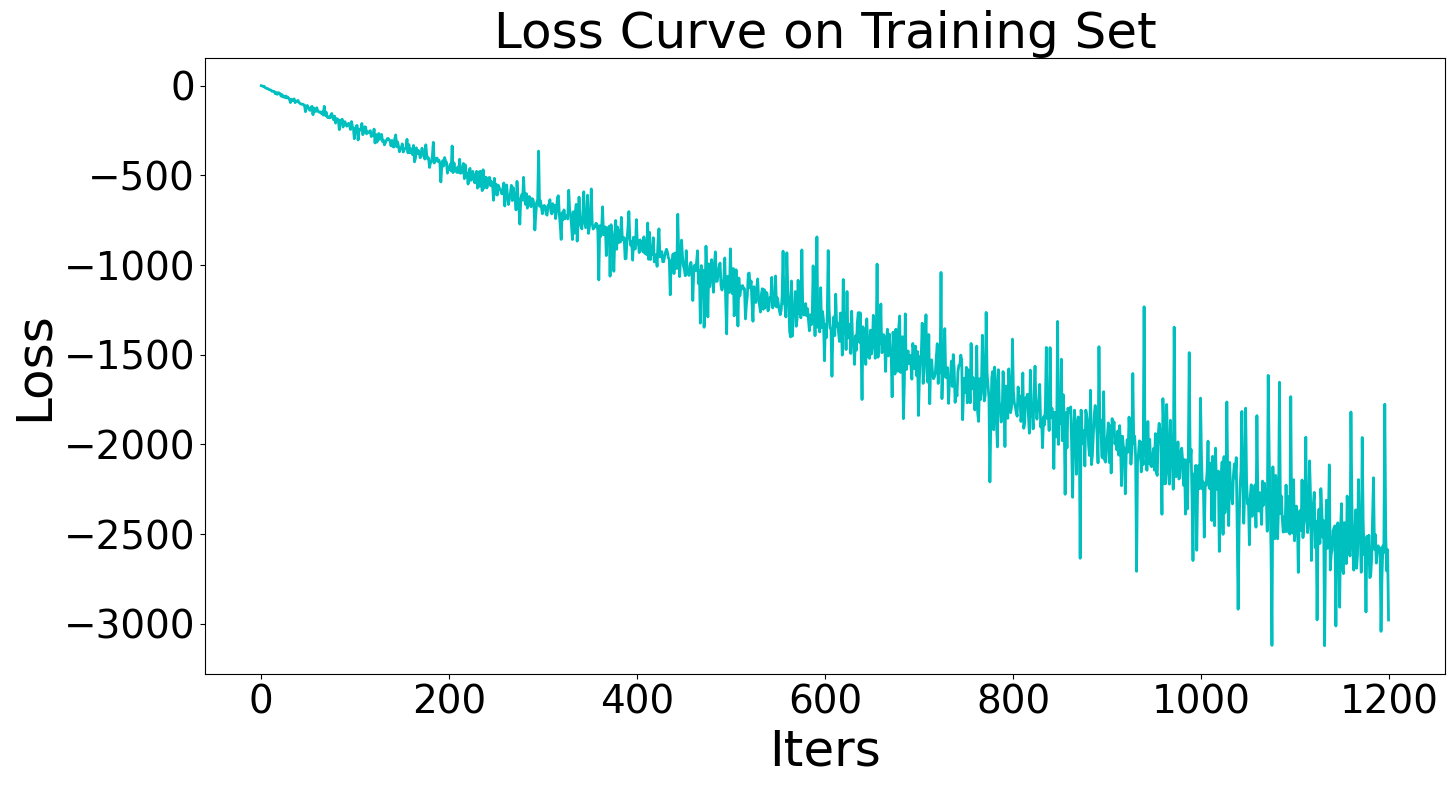

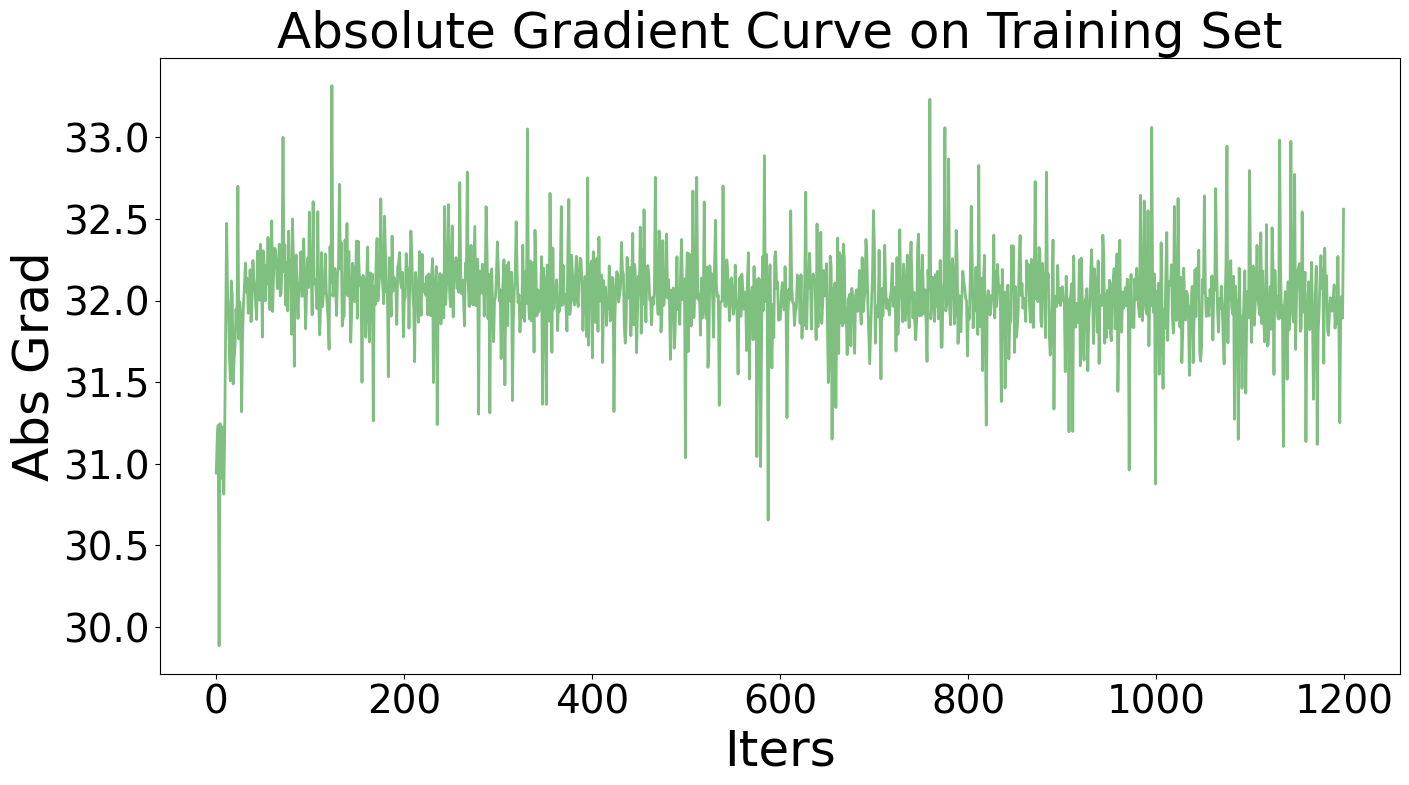

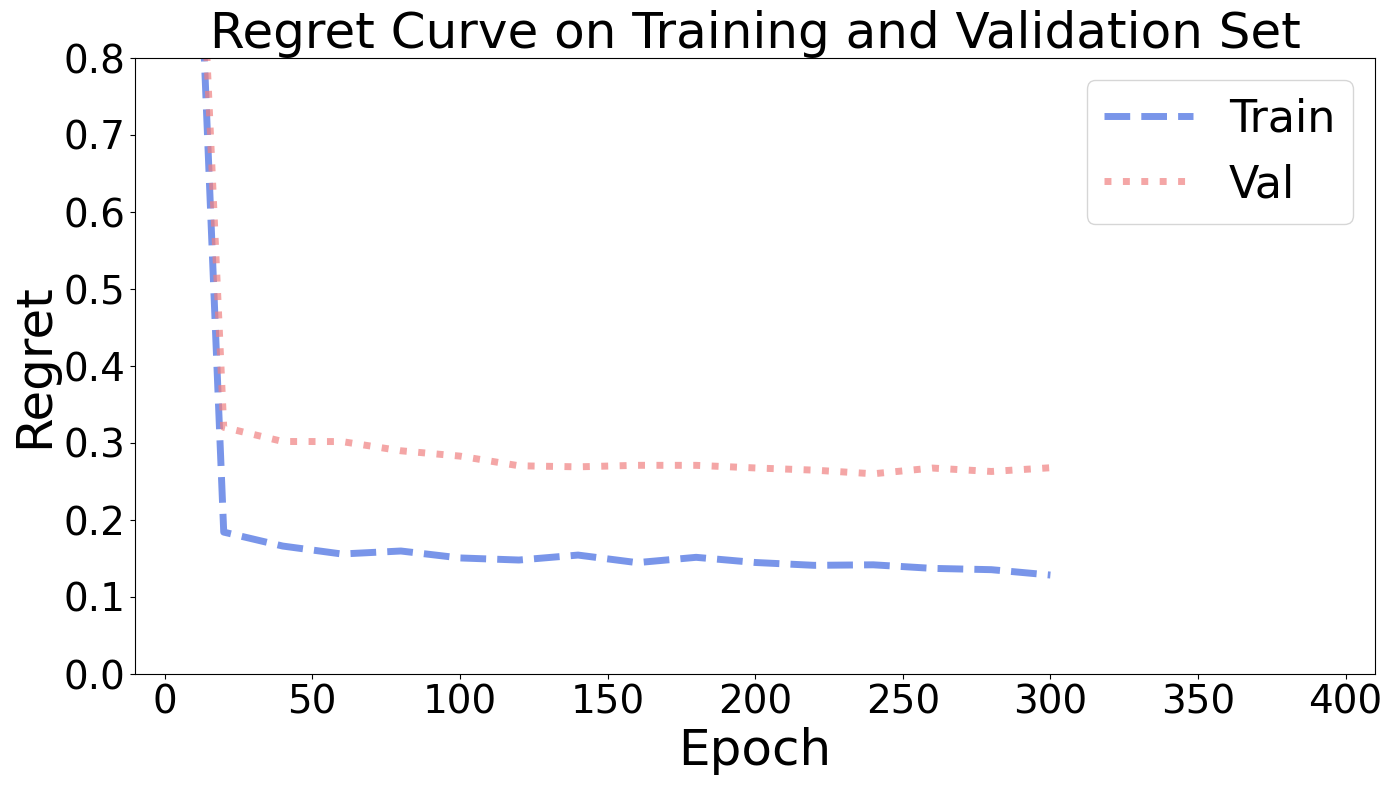

In [43]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)